In [3]:
import sys
sys.path.append('folder/path')

In [4]:
%cd folder/path

/content/drive/MyDrive/Git


# Setup

In [5]:
!pip install -r requirements.txt

In [6]:
import os
import torch
import glob
import time
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import segmentation_models_pytorch as smp
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, jaccard_score
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import random
import matplotlib.colors as mcolors
from skimage.io import imread, imshow

from skimage.io import imread
import albumentations as A
from typing import List

import datetime

In [7]:
def set_all_seeds(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_all_seeds()

Random seed set as 42


In [8]:
# DATASET
dataset_dir = "mangrove_dataset/"
# ADJUST THESE 2 VALUES DEPENDING ON THE TRAINING TIME
train_test_split = 0.5
n_samples_per_zone = 50
n_zones = 10
# Order of bands : B, G, R, nir, nir_vegetation, swir, ndvi, ndwi, ndmi
# Keep all bands by default and reduce if training takes too long (keep a minima the first 4 + ndvi and ndmi)
bands_to_keep = list(range(9))

# MODEL
num_channels = len(bands_to_keep)
num_classes = 1 # Mangrove class
encoder_name = "resnet50"
encoder_weights = None
activation = 'sigmoid' # Mangrove vs Non-Mangrove
use_augmentation = True
name_model = "UNet-Resnet50"
model_save_path_epochs = f'model/{name_model}/epochs/'
os.makedirs(model_save_path_epochs, exist_ok=True)
model_save_path_metrics = f'model/{name_model}/metrics/'
os.makedirs(model_save_path_metrics, exist_ok=True)

save_interval = 1

# TRAINING
batch_size = 32
learning_rate = 0.0001
num_epochs = 100


# COMPUTATION & PRINTS (PYTORCH LIGHTNING)
accelerator = 'gpu'
strategy =  'auto'#'ddp' if multiple GPUs otherwise leave emtpy if single GPU training
num_nodes = 1
gpus_per_node = 1
num_workers = 1
enable_progress_bar = True
progress_rate = 10

# Display random examples

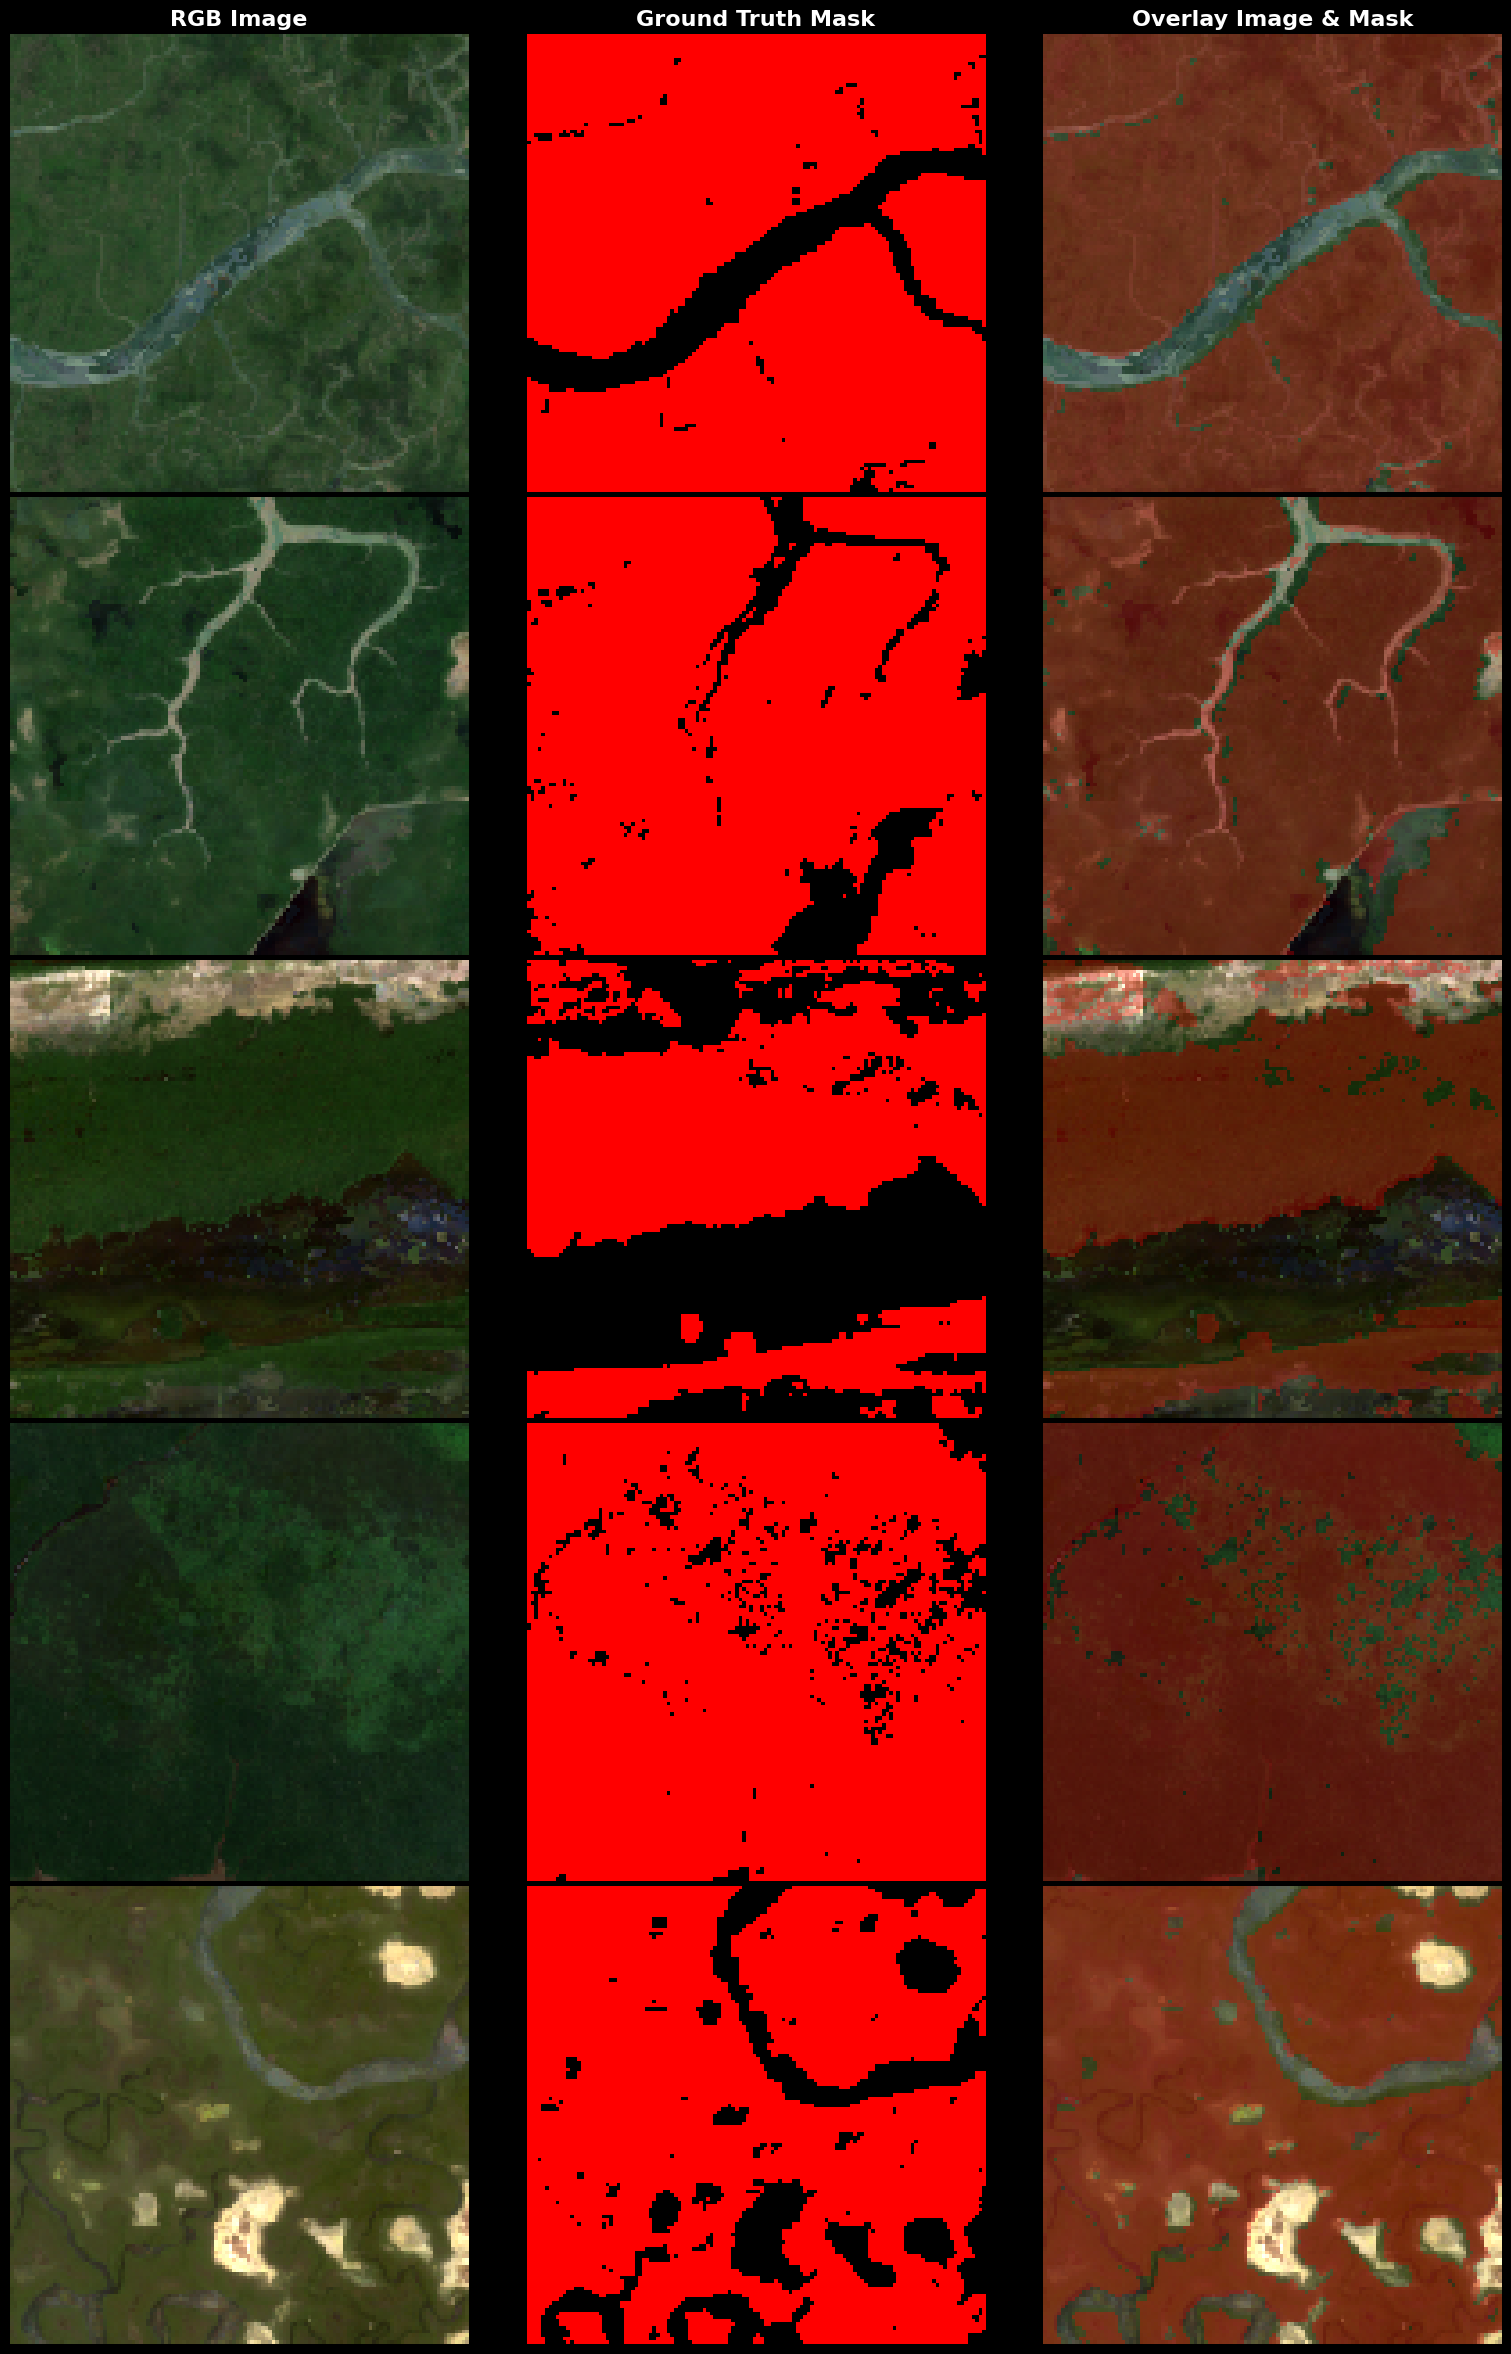

In [9]:
import image_utils  # Import the image_utils module

# Now you can use functions from image_utils
path_to_2020_sentinel_images_folder = "mangrove_dataset/sentinel_images/"
path_to_2020_masks_folder = "mangrove_dataset/masks/"

images = image_utils.get_all_file_paths(path_to_2020_sentinel_images_folder)
masks = image_utils.get_all_file_paths(path_to_2020_masks_folder)

image_utils.display_samples(images, masks, nb_samples=5)


# Mangrove Dataset

In [10]:
from dataset_utils import get_train_test_paths_by_zone, MangroveSegmentationDataset
import torch
from torch.utils.data import DataLoader

# Get train and test paths
full_paths_train, full_paths_test = get_train_test_paths_by_zone(dataset_dir, train_test_split, n_samples_per_zone, n_zones)

# Create dataset instances
dataset_train = MangroveSegmentationDataset(full_paths_train, bands_to_keep=bands_to_keep, use_augmentation=use_augmentation)
dataset_test = MangroveSegmentationDataset(full_paths_test, bands_to_keep=bands_to_keep, use_augmentation=False)

# Create DataLoaders
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)


# Model

In [11]:
model = smp.Unet(
    encoder_name = encoder_name,
    in_channels=num_channels,
    activation = activation,
    classes=1,
)

In [12]:
def count_parameters(model):
    # Number of parameters in millions
    return sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6

count_parameters(model)
# 32.54 for resnet50, 24.45 for resnet34, 14.34 for resnet18

32.539921

# Training

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.5, verbose=False)
model.to(device)

Using cuda:0 device


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(9, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [14]:
from train_model import train_final_model

# Call the training function
mean_loss_train, mean_f1_train, mean_iou_train, mean_accuracy_train, mean_loss_test, mean_f1_test, mean_iou_test, mean_accuracy_test, elapsed_time, best_model_filename, best_mean_iou_test = train_final_model(
    model,
    dataloader_train,
    dataloader_test,
    num_epochs,
    optimizer,
    scheduler,
    criterion,
    device,
    model_save_path_epochs,
    save_interval
)

EPOCH 1
Training...


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Testing...


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch 1/100, Train Loss: 0.6297, Train F1: 0.7754, Train IOU: 0.6342, Train Accuracy: 0.6704, Test Loss: 0.6399, Test F1: 0.7956, Test IOU: 0.6610, Test Accuracy: 0.6778, lr: 0.0001, Elapsed time: 0.18 minutes
Saving model...
EPOCH 2
Training...


100%|██████████| 8/8 [00:05<00:00,  1.59it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.71it/s]


Epoch 2/100, Train Loss: 0.5397, Train F1: 0.8359, Train IOU: 0.7187, Train Accuracy: 0.7567, Test Loss: 0.5973, Test F1: 0.8173, Test IOU: 0.6914, Test Accuracy: 0.7100, lr: 0.0001, Elapsed time: 0.32 minutes
Saving model...
EPOCH 3
Training...


100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Testing...


100%|██████████| 8/8 [00:03<00:00,  2.64it/s]


Epoch 3/100, Train Loss: 0.4942, Train F1: 0.8629, Train IOU: 0.7594, Train Accuracy: 0.7948, Test Loss: 0.5561, Test F1: 0.8363, Test IOU: 0.7189, Test Accuracy: 0.7428, lr: 0.0001, Elapsed time: 0.45 minutes
Saving model...
EPOCH 4
Training...


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 4/100, Train Loss: 0.4544, Train F1: 0.8784, Train IOU: 0.7835, Train Accuracy: 0.8179, Test Loss: 0.5160, Test F1: 0.8521, Test IOU: 0.7425, Test Accuracy: 0.7722, lr: 0.0001, Elapsed time: 0.59 minutes
Saving model...
EPOCH 5
Training...


100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.76it/s]


Epoch 5/100, Train Loss: 0.4326, Train F1: 0.8854, Train IOU: 0.7945, Train Accuracy: 0.8273, Test Loss: 0.4631, Test F1: 0.8699, Test IOU: 0.7699, Test Accuracy: 0.8069, lr: 0.0001, Elapsed time: 0.72 minutes
Saving model...
EPOCH 6
Training...


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.75it/s]


Epoch 6/100, Train Loss: 0.4137, Train F1: 0.8878, Train IOU: 0.7988, Train Accuracy: 0.8337, Test Loss: 0.4251, Test F1: 0.8773, Test IOU: 0.7816, Test Accuracy: 0.8217, lr: 0.0001, Elapsed time: 0.85 minutes
Saving model...
EPOCH 7
Training...


100%|██████████| 8/8 [00:04<00:00,  1.88it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.68it/s]


Epoch 7/100, Train Loss: 0.3907, Train F1: 0.8918, Train IOU: 0.8051, Train Accuracy: 0.8409, Test Loss: 0.3961, Test F1: 0.8849, Test IOU: 0.7937, Test Accuracy: 0.8366, lr: 0.0001, Elapsed time: 0.98 minutes
Saving model...
EPOCH 8
Training...


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Epoch 8/100, Train Loss: 0.3920, Train F1: 0.8885, Train IOU: 0.7997, Train Accuracy: 0.8360, Test Loss: 0.3861, Test F1: 0.8834, Test IOU: 0.7914, Test Accuracy: 0.8411, lr: 0.0001, Elapsed time: 1.11 minutes
EPOCH 9
Training...


100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


Epoch 9/100, Train Loss: 0.3644, Train F1: 0.9047, Train IOU: 0.8263, Train Accuracy: 0.8583, Test Loss: 0.3761, Test F1: 0.8882, Test IOU: 0.7991, Test Accuracy: 0.8474, lr: 0.0001, Elapsed time: 1.23 minutes
Saving model...
EPOCH 10
Training...


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.85it/s]


Epoch 10/100, Train Loss: 0.3822, Train F1: 0.8935, Train IOU: 0.8079, Train Accuracy: 0.8440, Test Loss: 0.3473, Test F1: 0.8993, Test IOU: 0.8171, Test Accuracy: 0.8613, lr: 0.0001, Elapsed time: 1.35 minutes
Saving model...
EPOCH 11
Training...


100%|██████████| 8/8 [00:04<00:00,  1.62it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.73it/s]


Epoch 11/100, Train Loss: 0.3571, Train F1: 0.8990, Train IOU: 0.8171, Train Accuracy: 0.8549, Test Loss: 0.3397, Test F1: 0.8989, Test IOU: 0.8166, Test Accuracy: 0.8619, lr: 0.0001, Elapsed time: 1.49 minutes
EPOCH 12
Training...


100%|██████████| 8/8 [00:04<00:00,  1.85it/s]


Testing...


100%|██████████| 8/8 [00:03<00:00,  2.66it/s]


Epoch 12/100, Train Loss: 0.3364, Train F1: 0.9099, Train IOU: 0.8348, Train Accuracy: 0.8692, Test Loss: 0.3694, Test F1: 0.8817, Test IOU: 0.7891, Test Accuracy: 0.8458, lr: 0.0001, Elapsed time: 1.61 minutes
EPOCH 13
Training...


100%|██████████| 8/8 [00:04<00:00,  1.97it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Epoch 13/100, Train Loss: 0.3430, Train F1: 0.9059, Train IOU: 0.8284, Train Accuracy: 0.8636, Test Loss: 0.3311, Test F1: 0.9029, Test IOU: 0.8233, Test Accuracy: 0.8692, lr: 0.0001, Elapsed time: 1.72 minutes
Saving model...
EPOCH 14
Training...


100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 14/100, Train Loss: 0.3219, Train F1: 0.9139, Train IOU: 0.8417, Train Accuracy: 0.8740, Test Loss: 0.3225, Test F1: 0.9056, Test IOU: 0.8277, Test Accuracy: 0.8722, lr: 0.0001, Elapsed time: 1.85 minutes
Saving model...
EPOCH 15
Training...


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.83it/s]


Epoch 15/100, Train Loss: 0.3255, Train F1: 0.9123, Train IOU: 0.8389, Train Accuracy: 0.8718, Test Loss: 0.3153, Test F1: 0.9122, Test IOU: 0.8387, Test Accuracy: 0.8774, lr: 0.0001, Elapsed time: 1.98 minutes
Saving model...
EPOCH 16
Training...


100%|██████████| 8/8 [00:04<00:00,  1.87it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


Epoch 16/100, Train Loss: 0.3336, Train F1: 0.9099, Train IOU: 0.8348, Train Accuracy: 0.8688, Test Loss: 0.3113, Test F1: 0.9127, Test IOU: 0.8396, Test Accuracy: 0.8780, lr: 0.0001, Elapsed time: 2.10 minutes
Saving model...
EPOCH 17
Training...


100%|██████████| 8/8 [00:05<00:00,  1.60it/s]


Testing...


100%|██████████| 8/8 [00:03<00:00,  2.55it/s]


Epoch 17/100, Train Loss: 0.3016, Train F1: 0.9222, Train IOU: 0.8560, Train Accuracy: 0.8857, Test Loss: 0.3019, Test F1: 0.9151, Test IOU: 0.8437, Test Accuracy: 0.8833, lr: 0.0001, Elapsed time: 2.25 minutes
Saving model...
EPOCH 18
Training...


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 18/100, Train Loss: 0.3051, Train F1: 0.9162, Train IOU: 0.8455, Train Accuracy: 0.8801, Test Loss: 0.3058, Test F1: 0.9111, Test IOU: 0.8369, Test Accuracy: 0.8795, lr: 0.0001, Elapsed time: 2.37 minutes
EPOCH 19
Training...


100%|██████████| 8/8 [00:05<00:00,  1.56it/s]


Testing...


100%|██████████| 8/8 [00:03<00:00,  2.66it/s]


Epoch 19/100, Train Loss: 0.3186, Train F1: 0.9125, Train IOU: 0.8405, Train Accuracy: 0.8748, Test Loss: 0.3029, Test F1: 0.9162, Test IOU: 0.8455, Test Accuracy: 0.8830, lr: 0.0001, Elapsed time: 2.50 minutes
Saving model...
EPOCH 20
Training...


100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.70it/s]


Epoch 20/100, Train Loss: 0.3049, Train F1: 0.9156, Train IOU: 0.8449, Train Accuracy: 0.8786, Test Loss: 0.2992, Test F1: 0.9164, Test IOU: 0.8459, Test Accuracy: 0.8828, lr: 0.0001, Elapsed time: 2.64 minutes
Saving model...
EPOCH 21
Training...


100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Testing...


100%|██████████| 8/8 [00:03<00:00,  2.44it/s]


Epoch 21/100, Train Loss: 0.3001, Train F1: 0.9179, Train IOU: 0.8484, Train Accuracy: 0.8806, Test Loss: 0.2957, Test F1: 0.9165, Test IOU: 0.8461, Test Accuracy: 0.8846, lr: 0.0001, Elapsed time: 2.77 minutes
Saving model...
EPOCH 22
Training...


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.74it/s]


Epoch 22/100, Train Loss: 0.2992, Train F1: 0.9183, Train IOU: 0.8490, Train Accuracy: 0.8813, Test Loss: 0.3053, Test F1: 0.9109, Test IOU: 0.8366, Test Accuracy: 0.8797, lr: 0.0001, Elapsed time: 2.90 minutes
EPOCH 23
Training...


100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.70it/s]


Epoch 23/100, Train Loss: 0.2891, Train F1: 0.9237, Train IOU: 0.8584, Train Accuracy: 0.8887, Test Loss: 0.3070, Test F1: 0.9075, Test IOU: 0.8310, Test Accuracy: 0.8760, lr: 0.0001, Elapsed time: 3.02 minutes
EPOCH 24
Training...


100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.71it/s]


Epoch 24/100, Train Loss: 0.3066, Train F1: 0.9143, Train IOU: 0.8423, Train Accuracy: 0.8750, Test Loss: 0.2866, Test F1: 0.9192, Test IOU: 0.8507, Test Accuracy: 0.8891, lr: 0.0001, Elapsed time: 3.13 minutes
Saving model...
EPOCH 25
Training...


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Testing...


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Epoch 25/100, Train Loss: 0.2868, Train F1: 0.9223, Train IOU: 0.8561, Train Accuracy: 0.8864, Test Loss: 0.3004, Test F1: 0.9111, Test IOU: 0.8369, Test Accuracy: 0.8788, lr: 0.0001, Elapsed time: 3.27 minutes
EPOCH 26
Training...


100%|██████████| 8/8 [00:03<00:00,  2.02it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Epoch 26/100, Train Loss: 0.3067, Train F1: 0.9152, Train IOU: 0.8439, Train Accuracy: 0.8764, Test Loss: 0.2905, Test F1: 0.9180, Test IOU: 0.8486, Test Accuracy: 0.8861, lr: 0.0001, Elapsed time: 3.38 minutes
EPOCH 27
Training...


100%|██████████| 8/8 [00:03<00:00,  2.00it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


Epoch 27/100, Train Loss: 0.3018, Train F1: 0.9143, Train IOU: 0.8423, Train Accuracy: 0.8768, Test Loss: 0.2802, Test F1: 0.9204, Test IOU: 0.8526, Test Accuracy: 0.8902, lr: 0.0001, Elapsed time: 3.49 minutes
Saving model...
EPOCH 28
Training...


100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.87it/s]


Epoch 28/100, Train Loss: 0.2958, Train F1: 0.9163, Train IOU: 0.8458, Train Accuracy: 0.8774, Test Loss: 0.2853, Test F1: 0.9179, Test IOU: 0.8485, Test Accuracy: 0.8862, lr: 0.0001, Elapsed time: 3.61 minutes
EPOCH 29
Training...


100%|██████████| 8/8 [00:04<00:00,  1.85it/s]


Testing...


100%|██████████| 8/8 [00:03<00:00,  2.66it/s]


Epoch 29/100, Train Loss: 0.2858, Train F1: 0.9233, Train IOU: 0.8579, Train Accuracy: 0.8877, Test Loss: 0.2833, Test F1: 0.9191, Test IOU: 0.8504, Test Accuracy: 0.8881, lr: 0.0001, Elapsed time: 3.74 minutes
EPOCH 30
Training...


100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.74it/s]


Epoch 30/100, Train Loss: 0.2834, Train F1: 0.9228, Train IOU: 0.8569, Train Accuracy: 0.8871, Test Loss: 0.2817, Test F1: 0.9209, Test IOU: 0.8535, Test Accuracy: 0.8908, lr: 0.0001, Elapsed time: 3.86 minutes
Saving model...
EPOCH 31
Training...


100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.75it/s]


Epoch 31/100, Train Loss: 0.2771, Train F1: 0.9249, Train IOU: 0.8604, Train Accuracy: 0.8916, Test Loss: 0.2990, Test F1: 0.9114, Test IOU: 0.8373, Test Accuracy: 0.8786, lr: 0.0001, Elapsed time: 3.99 minutes
EPOCH 32
Training...


100%|██████████| 8/8 [00:05<00:00,  1.58it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.69it/s]


Epoch 32/100, Train Loss: 0.2855, Train F1: 0.9207, Train IOU: 0.8533, Train Accuracy: 0.8857, Test Loss: 0.2855, Test F1: 0.9190, Test IOU: 0.8504, Test Accuracy: 0.8883, lr: 0.0001, Elapsed time: 4.12 minutes
EPOCH 33
Training...


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.89it/s]


Epoch 33/100, Train Loss: 0.2780, Train F1: 0.9238, Train IOU: 0.8586, Train Accuracy: 0.8907, Test Loss: 0.2761, Test F1: 0.9217, Test IOU: 0.8549, Test Accuracy: 0.8921, lr: 0.0001, Elapsed time: 4.23 minutes
Saving model...
EPOCH 34
Training...


100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.90it/s]


Epoch 34/100, Train Loss: 0.2784, Train F1: 0.9247, Train IOU: 0.8601, Train Accuracy: 0.8905, Test Loss: 0.2742, Test F1: 0.9229, Test IOU: 0.8571, Test Accuracy: 0.8935, lr: 0.0001, Elapsed time: 4.36 minutes
Saving model...
EPOCH 35
Training...


100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


Testing...


100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


Epoch 35/100, Train Loss: 0.2747, Train F1: 0.9258, Train IOU: 0.8619, Train Accuracy: 0.8923, Test Loss: 0.2733, Test F1: 0.9226, Test IOU: 0.8565, Test Accuracy: 0.8926, lr: 0.0001, Elapsed time: 4.49 minutes
EPOCH 36
Training...


100%|██████████| 8/8 [00:04<00:00,  1.84it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 36/100, Train Loss: 0.2810, Train F1: 0.9232, Train IOU: 0.8576, Train Accuracy: 0.8876, Test Loss: 0.2867, Test F1: 0.9191, Test IOU: 0.8505, Test Accuracy: 0.8875, lr: 0.0001, Elapsed time: 4.61 minutes
EPOCH 37
Training...


100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.84it/s]


Epoch 37/100, Train Loss: 0.2712, Train F1: 0.9251, Train IOU: 0.8610, Train Accuracy: 0.8925, Test Loss: 0.3000, Test F1: 0.9160, Test IOU: 0.8452, Test Accuracy: 0.8831, lr: 0.0001, Elapsed time: 4.73 minutes
EPOCH 38
Training...


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Testing...


100%|██████████| 8/8 [00:03<00:00,  2.61it/s]


Epoch 38/100, Train Loss: 0.2692, Train F1: 0.9270, Train IOU: 0.8641, Train Accuracy: 0.8938, Test Loss: 0.2773, Test F1: 0.9207, Test IOU: 0.8532, Test Accuracy: 0.8906, lr: 0.0001, Elapsed time: 4.85 minutes
EPOCH 39
Training...


100%|██████████| 8/8 [00:04<00:00,  1.88it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.76it/s]


Epoch 39/100, Train Loss: 0.2618, Train F1: 0.9298, Train IOU: 0.8689, Train Accuracy: 0.8975, Test Loss: 0.2782, Test F1: 0.9165, Test IOU: 0.8460, Test Accuracy: 0.8870, lr: 0.0001, Elapsed time: 4.97 minutes
EPOCH 40
Training...


100%|██████████| 8/8 [00:04<00:00,  1.86it/s]


Testing...


100%|██████████| 8/8 [00:03<00:00,  2.61it/s]


Epoch 40/100, Train Loss: 0.2633, Train F1: 0.9278, Train IOU: 0.8655, Train Accuracy: 0.8967, Test Loss: 0.2993, Test F1: 0.9068, Test IOU: 0.8297, Test Accuracy: 0.8751, lr: 0.0001, Elapsed time: 5.09 minutes
EPOCH 41
Training...


100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.85it/s]


Epoch 41/100, Train Loss: 0.2692, Train F1: 0.9243, Train IOU: 0.8594, Train Accuracy: 0.8905, Test Loss: 0.2862, Test F1: 0.9131, Test IOU: 0.8402, Test Accuracy: 0.8829, lr: 0.0001, Elapsed time: 5.21 minutes
EPOCH 42
Training...


100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.86it/s]


Epoch 42/100, Train Loss: 0.2641, Train F1: 0.9285, Train IOU: 0.8667, Train Accuracy: 0.8976, Test Loss: 0.2783, Test F1: 0.9171, Test IOU: 0.8471, Test Accuracy: 0.8867, lr: 0.0001, Elapsed time: 5.33 minutes
EPOCH 43
Training...


100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


Epoch 43/100, Train Loss: 0.2623, Train F1: 0.9272, Train IOU: 0.8645, Train Accuracy: 0.8947, Test Loss: 0.2776, Test F1: 0.9215, Test IOU: 0.8547, Test Accuracy: 0.8904, lr: 5e-05, Elapsed time: 5.44 minutes
EPOCH 44
Training...


100%|██████████| 8/8 [00:04<00:00,  1.90it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 44/100, Train Loss: 0.2647, Train F1: 0.9276, Train IOU: 0.8653, Train Accuracy: 0.8947, Test Loss: 0.2736, Test F1: 0.9220, Test IOU: 0.8556, Test Accuracy: 0.8914, lr: 5e-05, Elapsed time: 5.56 minutes
EPOCH 45
Training...


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.77it/s]


Epoch 45/100, Train Loss: 0.2673, Train F1: 0.9279, Train IOU: 0.8657, Train Accuracy: 0.8951, Test Loss: 0.2706, Test F1: 0.9217, Test IOU: 0.8550, Test Accuracy: 0.8917, lr: 5e-05, Elapsed time: 5.68 minutes
EPOCH 46
Training...


100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.87it/s]


Epoch 46/100, Train Loss: 0.2630, Train F1: 0.9247, Train IOU: 0.8601, Train Accuracy: 0.8936, Test Loss: 0.2676, Test F1: 0.9228, Test IOU: 0.8568, Test Accuracy: 0.8937, lr: 5e-05, Elapsed time: 5.79 minutes
EPOCH 47
Training...


100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.77it/s]


Epoch 47/100, Train Loss: 0.2529, Train F1: 0.9316, Train IOU: 0.8720, Train Accuracy: 0.9013, Test Loss: 0.2680, Test F1: 0.9227, Test IOU: 0.8567, Test Accuracy: 0.8939, lr: 5e-05, Elapsed time: 5.91 minutes
EPOCH 48
Training...


100%|██████████| 8/8 [00:04<00:00,  1.97it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Epoch 48/100, Train Loss: 0.2524, Train F1: 0.9336, Train IOU: 0.8756, Train Accuracy: 0.9026, Test Loss: 0.2691, Test F1: 0.9216, Test IOU: 0.8547, Test Accuracy: 0.8930, lr: 5e-05, Elapsed time: 6.02 minutes
EPOCH 49
Training...


100%|██████████| 8/8 [00:04<00:00,  1.97it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Epoch 49/100, Train Loss: 0.2679, Train F1: 0.9266, Train IOU: 0.8635, Train Accuracy: 0.8931, Test Loss: 0.2681, Test F1: 0.9217, Test IOU: 0.8549, Test Accuracy: 0.8929, lr: 5e-05, Elapsed time: 6.14 minutes
EPOCH 50
Training...


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.77it/s]


Epoch 50/100, Train Loss: 0.2575, Train F1: 0.9301, Train IOU: 0.8697, Train Accuracy: 0.8985, Test Loss: 0.2665, Test F1: 0.9225, Test IOU: 0.8563, Test Accuracy: 0.8937, lr: 5e-05, Elapsed time: 6.25 minutes
EPOCH 51
Training...


100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.76it/s]


Epoch 51/100, Train Loss: 0.2531, Train F1: 0.9316, Train IOU: 0.8721, Train Accuracy: 0.9003, Test Loss: 0.2683, Test F1: 0.9216, Test IOU: 0.8548, Test Accuracy: 0.8920, lr: 5e-05, Elapsed time: 6.37 minutes
EPOCH 52
Training...


100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.87it/s]


Epoch 52/100, Train Loss: 0.2623, Train F1: 0.9282, Train IOU: 0.8662, Train Accuracy: 0.8960, Test Loss: 0.2747, Test F1: 0.9216, Test IOU: 0.8548, Test Accuracy: 0.8906, lr: 5e-05, Elapsed time: 6.49 minutes
EPOCH 53
Training...


100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.88it/s]


Epoch 53/100, Train Loss: 0.2450, Train F1: 0.9336, Train IOU: 0.8757, Train Accuracy: 0.9031, Test Loss: 0.2789, Test F1: 0.9210, Test IOU: 0.8537, Test Accuracy: 0.8898, lr: 5e-05, Elapsed time: 6.60 minutes
EPOCH 54
Training...


100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Epoch 54/100, Train Loss: 0.2579, Train F1: 0.9288, Train IOU: 0.8673, Train Accuracy: 0.8968, Test Loss: 0.2701, Test F1: 0.9239, Test IOU: 0.8588, Test Accuracy: 0.8943, lr: 5e-05, Elapsed time: 6.72 minutes
Saving model...
EPOCH 55
Training...


100%|██████████| 8/8 [00:03<00:00,  2.03it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.90it/s]


Epoch 55/100, Train Loss: 0.2448, Train F1: 0.9338, Train IOU: 0.8760, Train Accuracy: 0.9037, Test Loss: 0.2669, Test F1: 0.9236, Test IOU: 0.8583, Test Accuracy: 0.8950, lr: 5e-05, Elapsed time: 6.83 minutes
EPOCH 56
Training...


100%|██████████| 8/8 [00:04<00:00,  1.90it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.87it/s]


Epoch 56/100, Train Loss: 0.2555, Train F1: 0.9322, Train IOU: 0.8731, Train Accuracy: 0.9008, Test Loss: 0.2647, Test F1: 0.9233, Test IOU: 0.8577, Test Accuracy: 0.8953, lr: 5e-05, Elapsed time: 6.95 minutes
EPOCH 57
Training...


100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.73it/s]


Epoch 57/100, Train Loss: 0.2519, Train F1: 0.9288, Train IOU: 0.8673, Train Accuracy: 0.8977, Test Loss: 0.2661, Test F1: 0.9228, Test IOU: 0.8569, Test Accuracy: 0.8940, lr: 5e-05, Elapsed time: 7.07 minutes
EPOCH 58
Training...


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


Epoch 58/100, Train Loss: 0.2492, Train F1: 0.9311, Train IOU: 0.8713, Train Accuracy: 0.9005, Test Loss: 0.2683, Test F1: 0.9206, Test IOU: 0.8531, Test Accuracy: 0.8916, lr: 5e-05, Elapsed time: 7.19 minutes
EPOCH 59
Training...


100%|██████████| 8/8 [00:03<00:00,  2.04it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Epoch 59/100, Train Loss: 0.2486, Train F1: 0.9315, Train IOU: 0.8721, Train Accuracy: 0.9012, Test Loss: 0.2627, Test F1: 0.9247, Test IOU: 0.8602, Test Accuracy: 0.8965, lr: 2.5e-05, Elapsed time: 7.30 minutes
Saving model...
EPOCH 60
Training...


100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Epoch 60/100, Train Loss: 0.2500, Train F1: 0.9304, Train IOU: 0.8700, Train Accuracy: 0.8997, Test Loss: 0.2653, Test F1: 0.9243, Test IOU: 0.8595, Test Accuracy: 0.8957, lr: 2.5e-05, Elapsed time: 7.42 minutes
EPOCH 61
Training...


100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.75it/s]


Epoch 61/100, Train Loss: 0.2451, Train F1: 0.9339, Train IOU: 0.8760, Train Accuracy: 0.9039, Test Loss: 0.2653, Test F1: 0.9237, Test IOU: 0.8583, Test Accuracy: 0.8953, lr: 2.5e-05, Elapsed time: 7.53 minutes
EPOCH 62
Training...


100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


Testing...


100%|██████████| 8/8 [00:03<00:00,  2.65it/s]


Epoch 62/100, Train Loss: 0.2463, Train F1: 0.9335, Train IOU: 0.8753, Train Accuracy: 0.9031, Test Loss: 0.2637, Test F1: 0.9235, Test IOU: 0.8581, Test Accuracy: 0.8949, lr: 2.5e-05, Elapsed time: 7.65 minutes
EPOCH 63
Training...


100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.77it/s]


Epoch 63/100, Train Loss: 0.2495, Train F1: 0.9329, Train IOU: 0.8743, Train Accuracy: 0.9013, Test Loss: 0.2635, Test F1: 0.9236, Test IOU: 0.8583, Test Accuracy: 0.8951, lr: 2.5e-05, Elapsed time: 7.77 minutes
EPOCH 64
Training...


100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.76it/s]


Epoch 64/100, Train Loss: 0.2501, Train F1: 0.9324, Train IOU: 0.8735, Train Accuracy: 0.9009, Test Loss: 0.2632, Test F1: 0.9238, Test IOU: 0.8585, Test Accuracy: 0.8953, lr: 2.5e-05, Elapsed time: 7.89 minutes
EPOCH 65
Training...


100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.77it/s]


Epoch 65/100, Train Loss: 0.2484, Train F1: 0.9329, Train IOU: 0.8744, Train Accuracy: 0.9024, Test Loss: 0.2625, Test F1: 0.9244, Test IOU: 0.8596, Test Accuracy: 0.8961, lr: 2.5e-05, Elapsed time: 8.01 minutes
EPOCH 66
Training...


100%|██████████| 8/8 [00:04<00:00,  1.97it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 66/100, Train Loss: 0.2447, Train F1: 0.9324, Train IOU: 0.8736, Train Accuracy: 0.9030, Test Loss: 0.2632, Test F1: 0.9245, Test IOU: 0.8598, Test Accuracy: 0.8958, lr: 2.5e-05, Elapsed time: 8.12 minutes
EPOCH 67
Training...


100%|██████████| 8/8 [00:04<00:00,  1.97it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.68it/s]


Epoch 67/100, Train Loss: 0.2454, Train F1: 0.9319, Train IOU: 0.8726, Train Accuracy: 0.9017, Test Loss: 0.2622, Test F1: 0.9248, Test IOU: 0.8604, Test Accuracy: 0.8962, lr: 2.5e-05, Elapsed time: 8.24 minutes
Saving model...
EPOCH 68
Training...


100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.70it/s]


Epoch 68/100, Train Loss: 0.2439, Train F1: 0.9315, Train IOU: 0.8719, Train Accuracy: 0.9019, Test Loss: 0.2617, Test F1: 0.9247, Test IOU: 0.8601, Test Accuracy: 0.8958, lr: 2.5e-05, Elapsed time: 8.37 minutes
EPOCH 69
Training...


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.85it/s]


Epoch 69/100, Train Loss: 0.2468, Train F1: 0.9322, Train IOU: 0.8732, Train Accuracy: 0.9022, Test Loss: 0.2603, Test F1: 0.9245, Test IOU: 0.8598, Test Accuracy: 0.8964, lr: 2.5e-05, Elapsed time: 8.48 minutes
EPOCH 70
Training...


100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


Epoch 70/100, Train Loss: 0.2388, Train F1: 0.9356, Train IOU: 0.8793, Train Accuracy: 0.9059, Test Loss: 0.2622, Test F1: 0.9231, Test IOU: 0.8574, Test Accuracy: 0.8949, lr: 2.5e-05, Elapsed time: 8.60 minutes
EPOCH 71
Training...


100%|██████████| 8/8 [00:04<00:00,  1.97it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.89it/s]


Epoch 71/100, Train Loss: 0.2612, Train F1: 0.9264, Train IOU: 0.8630, Train Accuracy: 0.8934, Test Loss: 0.2636, Test F1: 0.9232, Test IOU: 0.8575, Test Accuracy: 0.8948, lr: 2.5e-05, Elapsed time: 8.71 minutes
EPOCH 72
Training...


100%|██████████| 8/8 [00:03<00:00,  2.04it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.86it/s]


Epoch 72/100, Train Loss: 0.2560, Train F1: 0.9299, Train IOU: 0.8692, Train Accuracy: 0.8984, Test Loss: 0.2652, Test F1: 0.9234, Test IOU: 0.8580, Test Accuracy: 0.8948, lr: 2.5e-05, Elapsed time: 8.82 minutes
EPOCH 73
Training...


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Epoch 73/100, Train Loss: 0.2490, Train F1: 0.9321, Train IOU: 0.8730, Train Accuracy: 0.9014, Test Loss: 0.2648, Test F1: 0.9233, Test IOU: 0.8578, Test Accuracy: 0.8947, lr: 2.5e-05, Elapsed time: 8.93 minutes
EPOCH 74
Training...


100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


Epoch 74/100, Train Loss: 0.2377, Train F1: 0.9357, Train IOU: 0.8793, Train Accuracy: 0.9065, Test Loss: 0.2643, Test F1: 0.9235, Test IOU: 0.8581, Test Accuracy: 0.8948, lr: 2.5e-05, Elapsed time: 9.05 minutes
EPOCH 75
Training...


100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.88it/s]


Epoch 75/100, Train Loss: 0.2433, Train F1: 0.9327, Train IOU: 0.8739, Train Accuracy: 0.9027, Test Loss: 0.2628, Test F1: 0.9240, Test IOU: 0.8589, Test Accuracy: 0.8954, lr: 1.25e-05, Elapsed time: 9.17 minutes
EPOCH 76
Training...


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Epoch 76/100, Train Loss: 0.2429, Train F1: 0.9333, Train IOU: 0.8752, Train Accuracy: 0.9034, Test Loss: 0.2629, Test F1: 0.9243, Test IOU: 0.8595, Test Accuracy: 0.8958, lr: 1.25e-05, Elapsed time: 9.29 minutes
EPOCH 77
Training...


100%|██████████| 8/8 [00:03<00:00,  2.00it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


Epoch 77/100, Train Loss: 0.2442, Train F1: 0.9327, Train IOU: 0.8739, Train Accuracy: 0.9016, Test Loss: 0.2643, Test F1: 0.9236, Test IOU: 0.8582, Test Accuracy: 0.8950, lr: 1.25e-05, Elapsed time: 9.40 minutes
EPOCH 78
Training...


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


Epoch 78/100, Train Loss: 0.2362, Train F1: 0.9346, Train IOU: 0.8774, Train Accuracy: 0.9057, Test Loss: 0.2645, Test F1: 0.9239, Test IOU: 0.8587, Test Accuracy: 0.8952, lr: 1.25e-05, Elapsed time: 9.51 minutes
EPOCH 79
Training...


100%|██████████| 8/8 [00:03<00:00,  2.00it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


Epoch 79/100, Train Loss: 0.2385, Train F1: 0.9336, Train IOU: 0.8756, Train Accuracy: 0.9039, Test Loss: 0.2637, Test F1: 0.9239, Test IOU: 0.8587, Test Accuracy: 0.8954, lr: 1.25e-05, Elapsed time: 9.62 minutes
EPOCH 80
Training...


100%|██████████| 8/8 [00:03<00:00,  2.07it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.77it/s]


Epoch 80/100, Train Loss: 0.2424, Train F1: 0.9342, Train IOU: 0.8766, Train Accuracy: 0.9046, Test Loss: 0.2634, Test F1: 0.9240, Test IOU: 0.8590, Test Accuracy: 0.8956, lr: 1.25e-05, Elapsed time: 9.74 minutes
EPOCH 81
Training...


100%|██████████| 8/8 [00:04<00:00,  1.97it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


Epoch 81/100, Train Loss: 0.2332, Train F1: 0.9356, Train IOU: 0.8791, Train Accuracy: 0.9073, Test Loss: 0.2634, Test F1: 0.9243, Test IOU: 0.8595, Test Accuracy: 0.8958, lr: 1.25e-05, Elapsed time: 9.85 minutes
EPOCH 82
Training...


100%|██████████| 8/8 [00:03<00:00,  2.04it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Epoch 82/100, Train Loss: 0.2316, Train F1: 0.9373, Train IOU: 0.8820, Train Accuracy: 0.9090, Test Loss: 0.2628, Test F1: 0.9244, Test IOU: 0.8596, Test Accuracy: 0.8959, lr: 1.25e-05, Elapsed time: 9.96 minutes
EPOCH 83
Training...


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.89it/s]


Epoch 83/100, Train Loss: 0.2352, Train F1: 0.9352, Train IOU: 0.8785, Train Accuracy: 0.9067, Test Loss: 0.2634, Test F1: 0.9242, Test IOU: 0.8593, Test Accuracy: 0.8955, lr: 6.25e-06, Elapsed time: 10.08 minutes
EPOCH 84
Training...


100%|██████████| 8/8 [00:03<00:00,  2.05it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.88it/s]


Epoch 84/100, Train Loss: 0.2336, Train F1: 0.9361, Train IOU: 0.8800, Train Accuracy: 0.9069, Test Loss: 0.2624, Test F1: 0.9242, Test IOU: 0.8593, Test Accuracy: 0.8959, lr: 6.25e-06, Elapsed time: 10.19 minutes
EPOCH 85
Training...


100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


Epoch 85/100, Train Loss: 0.2422, Train F1: 0.9328, Train IOU: 0.8742, Train Accuracy: 0.9034, Test Loss: 0.2623, Test F1: 0.9243, Test IOU: 0.8594, Test Accuracy: 0.8958, lr: 6.25e-06, Elapsed time: 10.31 minutes
EPOCH 86
Training...


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.68it/s]


Epoch 86/100, Train Loss: 0.2423, Train F1: 0.9321, Train IOU: 0.8729, Train Accuracy: 0.9028, Test Loss: 0.2632, Test F1: 0.9244, Test IOU: 0.8597, Test Accuracy: 0.8956, lr: 6.25e-06, Elapsed time: 10.42 minutes
EPOCH 87
Training...


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.71it/s]


Epoch 87/100, Train Loss: 0.2323, Train F1: 0.9362, Train IOU: 0.8803, Train Accuracy: 0.9075, Test Loss: 0.2625, Test F1: 0.9243, Test IOU: 0.8594, Test Accuracy: 0.8957, lr: 6.25e-06, Elapsed time: 10.54 minutes
EPOCH 88
Training...


100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.76it/s]


Epoch 88/100, Train Loss: 0.2375, Train F1: 0.9354, Train IOU: 0.8786, Train Accuracy: 0.9062, Test Loss: 0.2625, Test F1: 0.9240, Test IOU: 0.8589, Test Accuracy: 0.8957, lr: 6.25e-06, Elapsed time: 10.66 minutes
EPOCH 89
Training...


100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


Epoch 89/100, Train Loss: 0.2306, Train F1: 0.9375, Train IOU: 0.8826, Train Accuracy: 0.9091, Test Loss: 0.2627, Test F1: 0.9236, Test IOU: 0.8582, Test Accuracy: 0.8954, lr: 6.25e-06, Elapsed time: 10.78 minutes
EPOCH 90
Training...


100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.71it/s]


Epoch 90/100, Train Loss: 0.2413, Train F1: 0.9333, Train IOU: 0.8750, Train Accuracy: 0.9036, Test Loss: 0.2626, Test F1: 0.9239, Test IOU: 0.8587, Test Accuracy: 0.8956, lr: 6.25e-06, Elapsed time: 10.90 minutes
EPOCH 91
Training...


100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


Testing...


100%|██████████| 8/8 [00:03<00:00,  2.65it/s]


Epoch 91/100, Train Loss: 0.2324, Train F1: 0.9367, Train IOU: 0.8810, Train Accuracy: 0.9079, Test Loss: 0.2635, Test F1: 0.9240, Test IOU: 0.8589, Test Accuracy: 0.8956, lr: 6.25e-06, Elapsed time: 11.02 minutes
EPOCH 92
Training...


100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.86it/s]


Epoch 92/100, Train Loss: 0.2504, Train F1: 0.9292, Train IOU: 0.8683, Train Accuracy: 0.8988, Test Loss: 0.2637, Test F1: 0.9243, Test IOU: 0.8595, Test Accuracy: 0.8960, lr: 6.25e-06, Elapsed time: 11.13 minutes
EPOCH 93
Training...


100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Epoch 93/100, Train Loss: 0.2350, Train F1: 0.9363, Train IOU: 0.8804, Train Accuracy: 0.9084, Test Loss: 0.2637, Test F1: 0.9244, Test IOU: 0.8596, Test Accuracy: 0.8959, lr: 6.25e-06, Elapsed time: 11.24 minutes
EPOCH 94
Training...


100%|██████████| 8/8 [00:03<00:00,  2.03it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Epoch 94/100, Train Loss: 0.2366, Train F1: 0.9356, Train IOU: 0.8791, Train Accuracy: 0.9072, Test Loss: 0.2632, Test F1: 0.9246, Test IOU: 0.8600, Test Accuracy: 0.8963, lr: 3.125e-06, Elapsed time: 11.36 minutes
EPOCH 95
Training...


100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


Epoch 95/100, Train Loss: 0.2348, Train F1: 0.9356, Train IOU: 0.8791, Train Accuracy: 0.9064, Test Loss: 0.2626, Test F1: 0.9247, Test IOU: 0.8601, Test Accuracy: 0.8965, lr: 3.125e-06, Elapsed time: 11.47 minutes
EPOCH 96
Training...


100%|██████████| 8/8 [00:03<00:00,  2.02it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.90it/s]


Epoch 96/100, Train Loss: 0.2360, Train F1: 0.9355, Train IOU: 0.8790, Train Accuracy: 0.9067, Test Loss: 0.2625, Test F1: 0.9246, Test IOU: 0.8600, Test Accuracy: 0.8964, lr: 3.125e-06, Elapsed time: 11.58 minutes
EPOCH 97
Training...


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Epoch 97/100, Train Loss: 0.2343, Train F1: 0.9368, Train IOU: 0.8813, Train Accuracy: 0.9078, Test Loss: 0.2628, Test F1: 0.9245, Test IOU: 0.8597, Test Accuracy: 0.8962, lr: 3.125e-06, Elapsed time: 11.69 minutes
EPOCH 98
Training...


100%|██████████| 8/8 [00:03<00:00,  2.02it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.85it/s]


Epoch 98/100, Train Loss: 0.2423, Train F1: 0.9346, Train IOU: 0.8773, Train Accuracy: 0.9047, Test Loss: 0.2628, Test F1: 0.9241, Test IOU: 0.8590, Test Accuracy: 0.8958, lr: 3.125e-06, Elapsed time: 11.80 minutes
EPOCH 99
Training...


100%|██████████| 8/8 [00:03<00:00,  2.00it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Epoch 99/100, Train Loss: 0.2491, Train F1: 0.9299, Train IOU: 0.8695, Train Accuracy: 0.8998, Test Loss: 0.2629, Test F1: 0.9242, Test IOU: 0.8592, Test Accuracy: 0.8959, lr: 3.125e-06, Elapsed time: 11.92 minutes
EPOCH 100
Training...


100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


Testing...


100%|██████████| 8/8 [00:02<00:00,  2.90it/s]

Epoch 100/100, Train Loss: 0.2407, Train F1: 0.9338, Train IOU: 0.8760, Train Accuracy: 0.9053, Test Loss: 0.2630, Test F1: 0.9247, Test IOU: 0.8601, Test Accuracy: 0.8962, lr: 3.125e-06, Elapsed time: 12.03 minutes


In [15]:
print(f"Elapsed time of {elapsed_time} seconds for {num_epochs} epochs => best test IOU = {best_mean_iou_test}")

Elapsed time of 721.9397995471954 seconds for 100 epochs => best test IOU = 0.8603990878129346


In [16]:
from train_model import save_metrics_to_file

lists = {
    "mean_loss_train": mean_loss_train,
    "mean_f1_train": mean_f1_train,
    "mean_iou_train": mean_iou_train,
    "mean_accuracy_train": mean_accuracy_train,
    "mean_loss_test": mean_loss_test,
    "mean_f1_test": mean_f1_test,
    "mean_iou_test": mean_iou_test,
    "mean_accuracy_test": mean_accuracy_test,
    "elapsed_time": elapsed_time,
    "best_model_filename": best_model_filename,
    "best_mean_iou_test": best_mean_iou_test
}

save_metrics_to_file(lists, model_save_path_metrics+"metrics.txt")

Lists data saved successfully.


# Plot training results

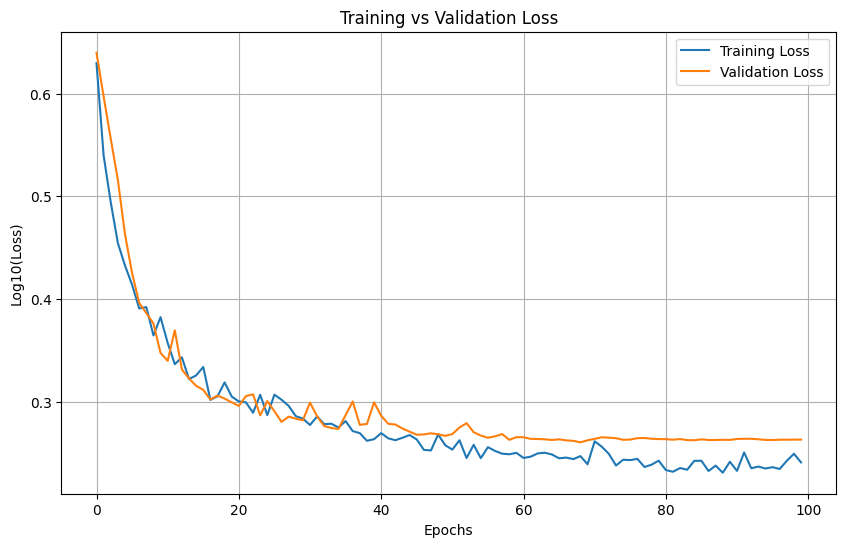

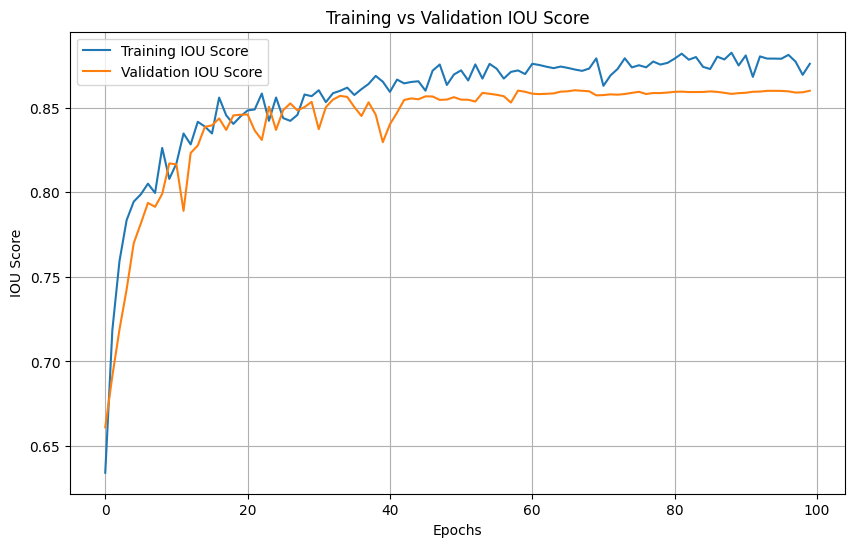

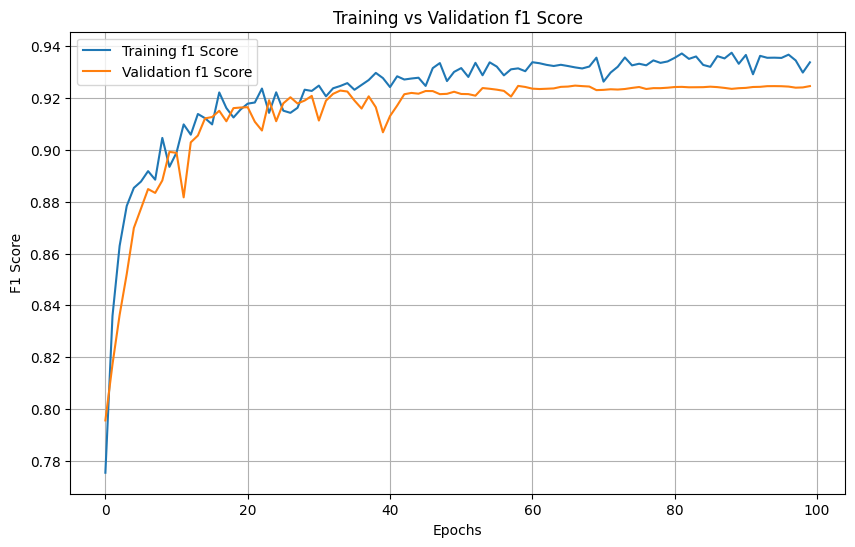

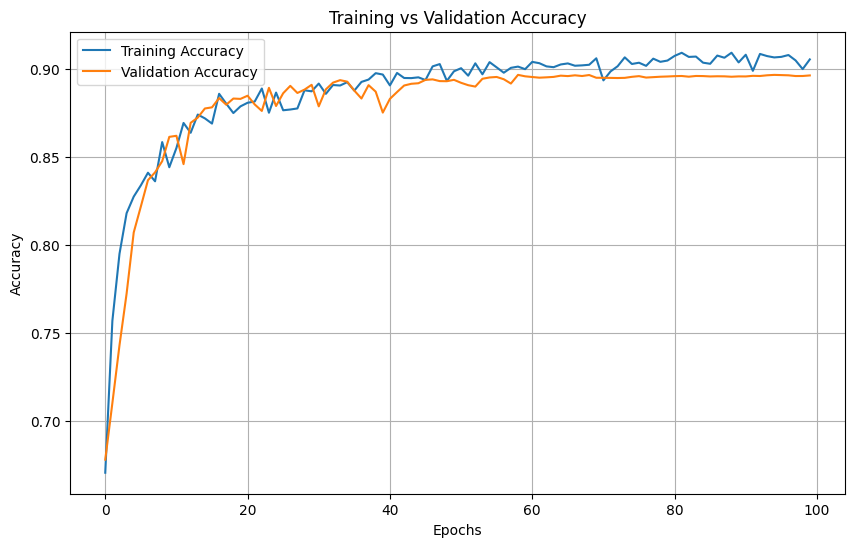

In [17]:
import plot_training_results

# Plot training and validation loss
plot_training_results.plot_train_val_loss(mean_loss_train, mean_loss_test)

# Plot training and validation IOU score
plot_training_results.plot_train_val_iou(mean_iou_train, mean_iou_test)

# Plot training and validation F1 score
plot_training_results.plot_train_val_f1(mean_f1_train, mean_f1_test)

# Plot training and validation accuracy
plot_training_results.plot_train_val_acc(mean_accuracy_train, mean_accuracy_test)


# Plot segmentation results

## Show inputs

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from plot_segmentation_results import plot_augmented_images

# Save images and mask
save_bands = f'model/{name_model}/plots_bands'
os.makedirs(save_bands, exist_ok=True)

# Call the function to plot augmented images
batch = next(iter(dataloader_test))
for idx, (test_image, true_mask) in enumerate(zip(batch[0], batch[1])):
    test_image_np = test_image.permute(1, 2, 0).cpu().detach().numpy()
    true_mask_np = true_mask.cpu().detach().numpy().squeeze().astype('int')
    plot_augmented_images(test_image_np, true_mask_np, idx, save_bands)



Output hidden; open in https://colab.research.google.com to view.

## Show predictions

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt

from plot_segmentation_results import plot_segmentation_results

# SHOW PREDICTIONS ON FULL BATCH
save_comparisons = f'model/{name_model}/plots_comparison'
os.makedirs(save_comparisons, exist_ok=True)

batch = next(iter(dataloader_test))
best_model = model
plot_segmentation_results(batch, device, model_save_path_epochs, best_model, best_model_filename, save_comparisons)

Output hidden; open in https://colab.research.google.com to view.